<a href="https://colab.research.google.com/github/abs711/makemore/blob/master/Makemore_usingMLP_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Makemore using a Multi-layer Perceptron

In [35]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
path = '/content/drive/MyDrive/build_makemore/'
words = open(path+'names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [38]:
len(words)

32033

In [39]:
chars = sorted(list(set(''.join(words)))) # Get all the characters
stoi = {s:i+1 for i,s in enumerate(chars)} #string to integer
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}


In [135]:
n_dim = 10 #embedding dimensions
block_size = 3 # context length i.e. num of character used to predict the next character
hu = 300 # num of hidden tanh layer units

def build_dataset(words,block_size):
  X, Y = [], []

  for w in words:#[:5]:
  #     print(w + '.')
      context = [0]*block_size
      for ch in w + '.':
          ix = stoi[ch]
          X.append(context)
          Y.append(ix)
  #         print(''.join(itos[i] for i in context), '--->', itos[ix])
          context = context[1:] + [ix]


  X = torch.tensor(X)
  Y = torch.tensor(Y)

  return X, Y

random.seed(42)
random.shuffle(words)

ntr = int(0.8*len(words))
nval = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:ntr],block_size)
Xval, Yval = build_dataset(words[ntr:nval],block_size)
Xts, Yts = build_dataset(words[nval:],block_size)


Xtr.shape, Xtr.dtype, Ytr.shape, Ytr.dtype

(torch.Size([182484, 3]), torch.int64, torch.Size([182484]), torch.int64)

In [136]:
Xval.shape, Xval.dtype, Yval.shape, Yval.dtype

(torch.Size([22869, 3]), torch.int64, torch.Size([22869]), torch.int64)

In [137]:
Xts.shape, Xts.dtype, Yts.shape, Yts.dtype

(torch.Size([22793, 3]), torch.int64, torch.Size([22793]), torch.int64)

In [138]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(27,n_dim,generator=g) # randomized two dimensional embedding for 27 characters

In [139]:
# C[5] or equivalently F.one_hot(torch.tensor(5), num_classes=27).float() @ C
# C[[5,6,7]] = C[torch.tensor([5,6,7])] #torch.tensor vs torch.Tensor
#C[X].shape = torch.Size([32, 3, 2])
# X[13,2] = 1 => C[X][13,2] = C[1]
emb = C[Xtr]
emb.shape

torch.Size([182484, 3, 10])

In [140]:
W1 = torch.randn((block_size*n_dim,hu),generator=g)
b1 = torch.randn(hu,generator=g)
W1.shape, b1.shape


(torch.Size([30, 300]), torch.Size([300]))

In [141]:
W2 = torch.randn((hu,27),generator=g)
b2 = torch.randn(27,generator=g)
W2.shape, b2.shape


(torch.Size([300, 27]), torch.Size([27]))

In [142]:
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))

17697


In [143]:
for p in parameters:
    p.requires_grad = True

In [144]:
def forward_pass(X):
  emb = C[X] #[32, 3, 2]
  emb = emb.view(-1,block_size*n_dim) #== torch.cat(torch.unbind(emb,1),dim=1) == torch.cat([emb[:,i,:] for i in range(block_size)],dim=1)
  h = torch.tanh(emb@W1 + b1) # see below or refer to broadcasting rules
    # h.shape
    # 32, 100
    # 1,  100
  logits = h@W2 + b2
  return logits


In [145]:
lre = torch.linspace(-3,0,1000)


lrs = 10**lre

In [146]:
lri = []
lossi = []
loss_val = []

In [149]:

for epc in range(1000):

    ix  = torch.randint(0,Xtr.shape[0], (32,)) # minibatch
    # emb = C[Xtr[ix]] #[32, 3, 2]
    # emb = emb.view(-1,block_size*n_dim) #== torch.cat(torch.unbind(emb,1),dim=1) == torch.cat([emb[:,i,:] for i in range(block_size)],dim=1)
    # h = torch.tanh(emb@W1 + b1) # see below or refer to broadcasting rules
    # # h.shape
    # # 32, 100
    # # 1,  100
    # logits = h@W2 + b2
    # # count = logits.exp()
    # # probs = count/count.sum(1, keepdims=True)
    # # loss = -probs[torch.arange(32), Y].log().mean()
    logits = forward_pass(Xtr[ix])
    loss = F.cross_entropy(logits, Ytr[ix]) # Efficient Forward and Backward pass; Also, prevent overflow due to exponentiation of large logits
    if epc%100==0:
        print('epc:', epc, 'loss:', loss.item())

    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.01 #lrs[epc]

    for p in parameters:
        p.data += -lr*p.grad

    loss_dev = F.cross_entropy(forward_pass(Xval), Yval)

    lri.append(lr)
    lossi.append(loss.item())
    loss_val.append(loss_dev.item())


epc: 0 loss: 5.561980724334717
epc: 100 loss: 2.7163684368133545
epc: 200 loss: 3.924960136413574
epc: 300 loss: 3.525343418121338
epc: 400 loss: 3.102931261062622
epc: 500 loss: 2.7950594425201416
epc: 600 loss: 3.800408124923706
epc: 700 loss: 2.584056854248047
epc: 800 loss: 3.7844295501708984
epc: 900 loss: 2.304363965988159


loss_train:  3.2938590049743652 loss_val: 4.471419811248779


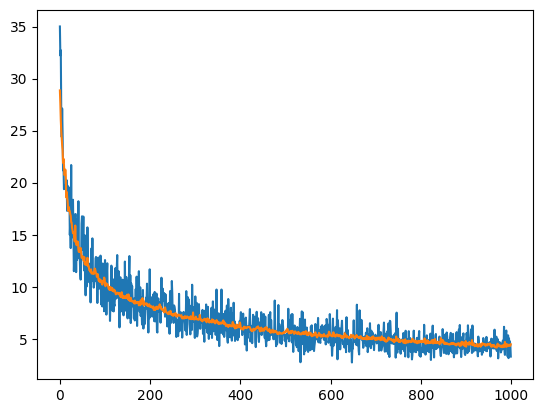

In [148]:
plt.plot(lossi)
plt.plot(loss_val)

print("loss_train: ",lossi[-1],"loss_val:", loss_val[-1])

In [72]:
emb = C[X[ix]] #[32, 3, 2]
emb = emb.view(-1,block_size*n_dim)
h = torch.tanh(emb@W1 + b1)
logits = h@W2 + b2
loss = F.cross_entropy(logits, Y[ix])
print('loss:', loss.item())


loss: 2.3376739025115967


tensor(17.7697)